In [1]:
import matplotlib.pyplot as plt
import numpy as np

import cmath

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

scaling = 1
r = 5
degree = 3 # degree of the target function


#Where should i put global r? Init looks resonable for me
class parallel_Qt_Device:
    def __init__(self, n_layers = 1):
        self.wires = n_layers
        self.circuit_length = range(n_layers)
        self.qc = QuantumCircuit(n_layers)
    
    def run(self, weights, x=None):
        self.qc = QuantumCircuit(self.wires, self.wires)
        self.W(weights[0])
        self.S(x)  
        self.W(weights[1])
    
        
        return self.observe_wire(wires=0)
    
    
    #Used to observe the wires equivalent of qml.expval(qml.PauliZ)
    #Should change to more general version of Pauli matrix as observable
    #using this link https://qiskit.org/ecosystem/ibm-runtime/tutorials/how-to-getting-started-with-estimator.html
    #Function differs from the model why?shifted to the top
    def observe_wire(self, wires=0, observable=(QuantumCircuit.z, 0)):
        op = (self.wires-1)*'I' + 'Z'
        observable = SparsePauliOp(op)
        estimator = Estimator()
        
        job = estimator.run(self.qc, observable)
        result = job.result()
        
        return result.values[0]
    
    def StronglyEntanglingLayers(self, weights, wires = None):
        if wires is None:
            wires = self.circuit_length
        elif not isinstance(wires, list):
            print("Wires Require One dimensional List!")
            return
        else:
            #check the shape of the list
            pass
        
        if self.wires <= 1:
            print("Cannot create such a circuit because you need to have more than 1 qubit!")

        #This part does not cover ranges of the qml.StronglyEntanglingLayers
        for layer in range(weights.shape[0]):
            for i in wires:
            
                thetas = weights[layer][i]
                
                self.qc.u(thetas[0],thetas[1], thetas[2], i)
            for j in wires[:-1]:
                self.qc.cx(j, j+1)
            self.qc.cx(i, 0)
            
    def S(self, x):
        """Data encoding circuit block."""
        for w in self.circuit_length:
            self.qc.rx(scaling*x, w)
    
    def W(self, theta):
        """Trainable circuit block."""
        self.StronglyEntanglingLayers(theta)
        
    def circuit_info(self):
        print("Length of the circuit: {}".format(self.circuit_length))
        
    
    def draw(self):
        # Draw the circuit
        diagram = circuit_drawer(self.qc, output='text')
        print(diagram)
        #self.qc.draw()

    def save_circuit_image(self, filename:str):
        self.qc.draw('mpl', filename=filename)




In [3]:
scaling = 1 # scaling of the data
coeffs = [0.15 + 0.15j]*degree # coefficients of non-zero frequencies
coeff0 = 0.1 # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series of degree, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = complex(0, scaling*(idx+1)*x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

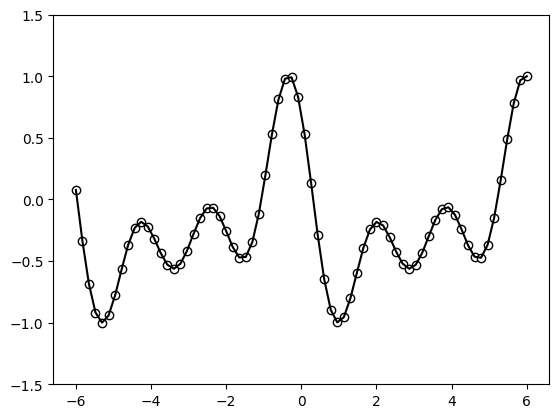

In [4]:
from sklearn.preprocessing import MinMaxScaler

x = np.linspace(-6, 6, 70)
data = np.array([target_function(x_) for x_ in x])

# Reshape the data to make it 2D
data = data.reshape(-1, 1)

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on your data and transform it
target_y = scaler.fit_transform(data).flatten()

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-(degree/2), (degree/2))
plt.show()

In [5]:


p_qt = parallel_Qt_Device(r)
p_qt.circuit_info()



Length of the circuit: range(0, 5)


In [6]:
#OBSERVABLE?? What should be stabilizer?
#Draving is kinda odd there is only 1 Rx?
#Wave function at the bottom also weird looking

      ┌─────────────────────────┐                                     »
q_0: ─┤ U(2.3533,5.9735,4.5993) ├───■─────────────────────────────────»
     ┌┴─────────────────────────┴┐┌─┴─┐     ┌────────────────────────┐»
q_1: ┤ U(3.7615,0.98029,0.98014) ├┤ X ├──■──┤ U(2.714,1.8298,3.8444) ├»
     └┬──────────────────────────┤└───┘┌─┴─┐└────────────────────────┘»
q_2: ─┤ U(0.36495,5.4423,3.7769) ├─────┤ X ├────────────■─────────────»
      ├─────────────────────────┬┘     └───┘          ┌─┴─┐           »
q_3: ─┤ U(4.449,0.12934,6.0941) ├─────────────────────┤ X ├───────────»
      ├─────────────────────────┤                     └───┘           »
q_4: ─┤ U(5.2304,1.3342,1.1424) ├─────────────────────────────────────»
      └─────────────────────────┘                                     »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                 ┌───┐┌────────────────────────

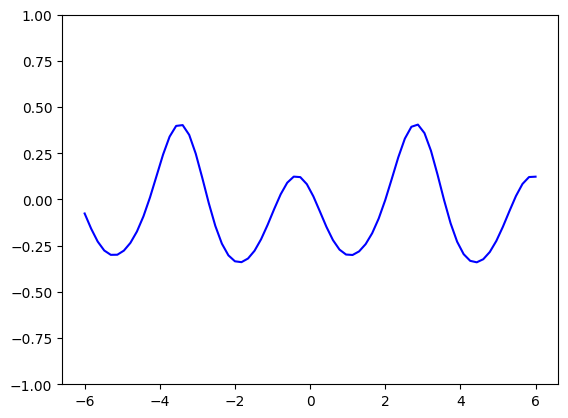

In [7]:
trainable_block_layers = 3
weights = 2*np.pi*np.random.random(size=(2, trainable_block_layers, r, 3))

x = np.linspace(-6, 6, 70)
random_quantum_model_y = [p_qt.run(weights, x=x_) for x_ in x]
p_qt.draw()
p_qt.save_circuit_image('./part2/Circuits/r={}&degree={}_qc.png'.format(r, degree))

init_weights = random_quantum_model_y

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [8]:
from qiskit.algorithms.optimizers import ADAM as AdamOptimizer
from scipy.optimize import minimize

def cost(weights, x, y):
    #print("Weights in cost func: {}".format(weights))
    weights=np.reshape(weights, w_shape)
    #print("REWeights in cost func: {}".format(weights.shape))

    predictions = [p_qt.run(weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

w_shape = weights.shape

max_steps = 1
maxiter = 60
lr=0.3
opt = AdamOptimizer(maxiter=maxiter, lr=lr)
batch_size = 25
cst = []  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    #print("Shape of x: {}".format(x_batch.shape))
    #print("Shape of y: {}".format(y_batch.shape))
    #print("Shape of w: {}".format(np.sum(weights,axis=1)))
    
    # Update the weights by one optimizer step
    res = opt.minimize(lambda w: cost(w, x, target_y), weights.reshape(-1), cst=cst)

    weights = res.x

    #print("Weights after minimize {}".format(weights))

    # Save, and possibly print, the current cost
    #c = cost(weights, x, target_y)
    #cst.append(c)
    #if (step + 1) % 10 == 0:
    #print("Cost at step {0:3}: {1}".format(step + 1, cst))

Cost at step   1: 2.6586480432058486
Cost at step   2: 1.8788992884310496
Cost at step   3: 1.4176559612747472
Cost at step   4: 1.169551055202961
Cost at step   5: 0.9801717066138822
Cost at step   6: 0.8626053377761391
Cost at step   7: 0.7756643241155953
Cost at step   8: 0.6816037814310544
Cost at step   9: 0.604791503026786
Cost at step  10: 0.5686746421405662
Cost at step  11: 0.5357548719679058
Cost at step  12: 0.5171432282926279
Cost at step  13: 0.44877385901895545
Cost at step  14: 0.42096922406582926
Cost at step  15: 0.42675813571396076
Cost at step  16: 0.38226723984240096
Cost at step  17: 0.3403094278202673
Cost at step  18: 0.3276814185972912
Cost at step  19: 0.33144644705973536
Cost at step  20: 0.32096143762452745
Cost at step  21: 0.30258197352374144
Cost at step  22: 0.2787720290556177
Cost at step  23: 0.27731384344926924
Cost at step  24: 0.2689247771859324
Cost at step  25: 0.2445105082285144
Cost at step  26: 0.2228706380291222
Cost at step  27: 0.207044239814

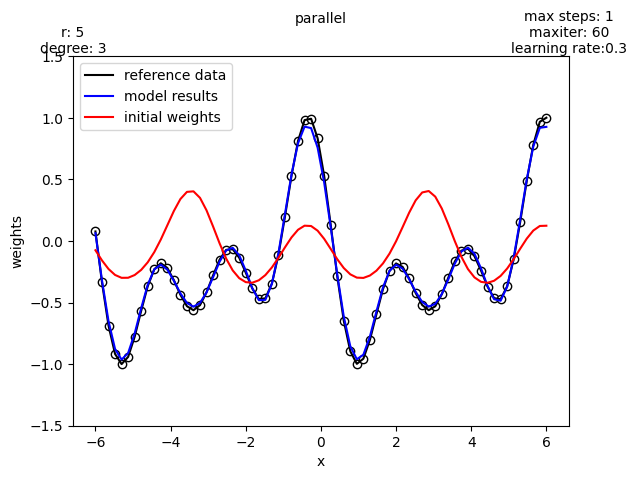

In [9]:
weights = np.reshape(weights, w_shape)
predictions = [p_qt.run(weights, x=x_) for x_ in x]


# Annotate with extra information
extra_info = f'r: {r}\ndegree: {degree}'
plt.annotate(extra_info, xy=(0, 1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
extra_info = 'parallel'
plt.annotate(extra_info, xy=(0.5, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='center')

extra_info = f'max steps: {max_steps}\nmaxiter: {maxiter}\nlearning rate:{0.3}'
plt.annotate(extra_info, xy=(1, 1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')


plt.plot(x, target_y, c='black', label = 'reference data')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue', label = 'model results')
plt.plot(x, init_weights, c='r', label = 'initial weights')
plt.ylim(-(degree/2), (degree/2))
# Add labels and a legend
plt.xlabel('x')
plt.ylabel('weights')
plt.legend()

plt.savefig("./part2/Freq_Graphs/parallel_attributes_r={}_degree={}_step={}_maxiter={}.png".format(r, degree,max_steps, maxiter))

plt.show()

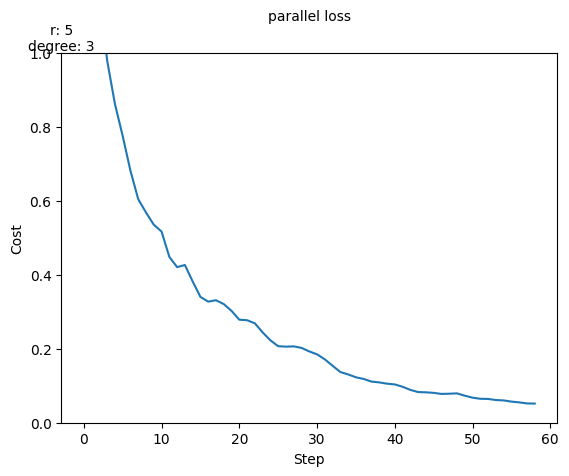

In [10]:
# Annotate with extra information
extra_info = f'r: {r}\ndegree: {degree}'
plt.annotate(extra_info, xy=(0, 1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
extra_info = 'parallel loss'
plt.annotate(extra_info, xy=(0.5, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='center')

cst = cst[1:]
#plt.yscale('log')
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 1)
plt.savefig("./part2/Loss_Func_Graphs/parallel_loss_attributes_r={}_degree={}_step={}_maxiter={}.png".format(r, degree,max_steps, maxiter))
plt.show()

In [11]:
print(len(cst))

59


In [12]:
def write_attributes_to_file(attributes, filename):
    # Write each attribute on a new line
    with open(filename, 'w') as file:
        for key, value in attributes.items():
            file.write(f"{key}: {value}\n")

file_name = f'parallel_attributes_r={r}_degree={degree}.txt'

attributes_to_store = {
    'x' : x.tolist(),
    'init_weights': init_weights,
    'predictions': predictions,
    'target_y': target_y.tolist(),
    'degree' : degree,
    'r' : r,
    'cost' : cst
}

write_attributes_to_file(attributes_to_store, file_name)